# Table of Contents

- **Loading text**
- **Text preprocessing**
- **Text vectorization**
- **Train and test splitting**
- **Training a classification model**
    - Logistic Regression Classifier
    - Naive Bayes Classifier
    - SVM Classifier
    - KNN Classifier
    - Decision Tree classifier
    - MLP Classifier
- **Exercise**

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

Now we will illustrate the main functionalities of scikit-learn when dealing with texts.
We will go through a typical text mining pipeline where our goal is to train a machine learning model that classifies texts scraped from company website into two classes:

* 0: Text from a non-software company website.
* 1: Text from a software company website.

## Loading text

We will use the Pandas `pd.read_csv()` function to read in the textfiles containing our data.

In [2]:
labelled_data = pd.read_csv("data/labelled_data.txt", sep="\t", encoding="utf-8", error_bad_lines=False,index_col = 0)
labelled_data.head()

,url,text,software
ID,,,
0,http://autzen-reimers.de,Seite: « 1 / 0 » « 1 / 0 »AUTZEN & REIMERSARCH...,0
1,https://ibos-goerlitz.de/,Das Ingenieurbüro IBOS GmbH wurde am 17.09.199...,0
2,https://kaizhong-vogt.de/,capanne.gittinger.de,0
3,https://baecker-holland.de/,Klicken Sie hier um zu unserem Kon­takt­for­mu...,0
4,https://www.vbhnr.de/privatkunden.html,Um Ihnen eine bessere Nutzung unserer Seite zu...,0


As we can see, our data is in a table format with 4 columns:

* **ID**: unique identifiers for each observation
* **url**: the website address from where text was downloaded
* **text**: the downloaded website text
* **software**: the label which tells us whether a website is from a software company ("1") or not ("0")

Using Pandas, we can perform some preliminary **data exploration** to check the characteristics of our data set.

In [3]:
n_samples, n_cols = labelled_data.shape
n_software = labelled_data["software"].sum()

print("number of documents:", n_samples)
print("number of columns:", n_cols)
print("number of 'software' documents:", n_software)
print("number of 'non-software' documents:", n_samples - n_software)

number of documents: 2000
number of columns: 3
number of 'software' documents: 284
number of 'non-software' documents: 1716


Alternatively you can use `value_counts()`.

In [4]:
 labelled_data["software"].value_counts()

0    1716
1     284
Name: software, dtype: int64

Check the statistics of the length of our pieces of text:

In [5]:
labelled_data["text"].apply(len).describe()

count      2000.000000
mean       2558.813500
std        5144.796468
min           1.000000
25%         703.000000
50%        1472.500000
75%        2788.500000
max      135504.000000
Name: text, dtype: float64

We can also easily plot the distribution of website text lengths by using pandas `plot()` method and passing the keywords for a histogram with 100 bins:

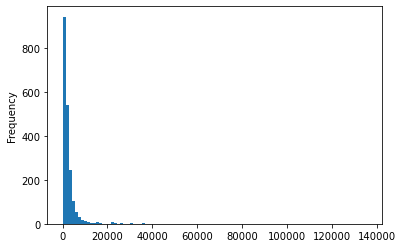

In [6]:
labelled_data["text"].apply(len).plot(kind="hist", bins=100)


We can also print some website text, just to get the feeling of the characteristics of the texts we must deal with:

In [7]:
print(labelled_data["text"][0], '\n')
print(labelled_data["text"][1], '\n')
print(labelled_data["text"][2], '\n')

Seite: « 1 / 0 » « 1 / 0 »AUTZEN & REIMERSARCHITEKTEN 

Das Ingenieurbüro IBOS GmbH wurde am 17.09.1990 in Görlitz gegründet. Unser Handlungsschwerpunkt liegt auf dem Gebiet der Siedlungswasserwirtschaft, des kommunalen Tiefbaues, der kommunalen Infrastruktur, des Wasserbaues, der Tragwerksplanung sowie der Bauleitungsplanung und Landschaftsplanung. In einem erfahrenen Team erstellen wir Planungen in allen Leistungsphasen der HOAI inklusive der Örtlichen Bauüberwachung und Sicherheits- und Gesundheitsschutzkoordination sowie Studien, Konzeptionen, Wirtschaftlichkeitsbetrachtungen und strategische Planungen. Als unabhängiges Ingenieurbüro sind wir frei von Interessen Dritter. Gern sind wir auch für Sie tätig – wir freuen uns über Ihre ! Wir suchen einen… Ihre Bewerbung richten Sie bitte an die unter aufgeführte Adresse, gern auch per E-Mail. Mitgeschickte Dateien nur im PDF-Format (keine ZIP-Datei). Am 20.09.2018 fand unsere im Gäste- und Tagungshaus KOMENSKÝ in Herrnhut statt. 100%iges

## Text preprocessing

The preliminary data exploration revealed some characteristics of the text, for example:

* We also may want to standardise all characters to lowercase, such that "Software" and "software" are recognized as the same words.
* There are quiet some websites with texts that are smaller than 500 characters and some even had only a single character in their "text" column.
* There are quite a lot of special characters (e.g. "€" or "§") and numbers in the text

Before feeding textual data to machine learning algorithms, it is often the case to preprocess the texts to remove unwanted documents, and to *normalize* the texts by removing clear noisy content.

We convert all characters to lowercase:

In [8]:
labelled_data['text'] = labelled_data["text"].apply(lambda text: str(text).lower())
labelled_data['text'].head()

ID
0    seite: « 1 / 0 » « 1 / 0 »autzen & reimersarch...
1    das ingenieurbüro ibos gmbh wurde am 17.09.199...
2                                 capanne.gittinger.de
3    klicken sie hier um zu unserem kon­takt­for­mu...
4    um ihnen eine bessere nutzung unserer seite zu...
Name: text, dtype: object

We remove the documents with less than 500 characters:

In [9]:
labelled_data = labelled_data[labelled_data["text"].apply(len) > 499]
labelled_data.shape

(1649, 3)

We exclude special characters from the further analysis. We will import a python's "regular expression" operations and apply its `sub("FILTER", "REPLACE_STRING")` function to the text column of our labelled dataset. We submit the `sub()` function with a regular expression telling it to delete all characters in the text that are not part of this list of characters: "`abcdefghijklmnopqrstuvwxyzäöüß& `" (note the final whitespace char!).

In [10]:
import re

labelled_data["text"] = labelled_data["text"].apply(lambda text: re.sub("[^abcdefghijklmnopqrstuvwxyzäöüß& ']", "", str(text)))
labelled_data.head()

,url,text,software
ID,,,
1,https://ibos-goerlitz.de/,das ingenieurbüro ibos gmbh wurde am in görli...,0
3,https://baecker-holland.de/,klicken sie hier um zu unserem kontaktformular...,0
4,https://www.vbhnr.de/privatkunden.html,um ihnen eine bessere nutzung unserer seite zu...,0
5,https://www.whg-ebw.de/,informieren sie sich über die wohngebiete der ...,0
6,https://www.wittich.de/,amts und mitteilungsblätter reisemagazine maga...,0


## Text vectorization

The machine learning algorithms we will use require us to give numerical data to them. Raw text data as an input will not work! This means that we have to transfer our texts to some kind of numerical representation without loosing too much information. Transferring a text from a sequence of characters to a vector of numbers is called **text vectorization**.

![text_vectorization.png](images/text_vectorization.png)

There are many different ways to vectorize texts, from fancy techniques like [word embeddings](https://en.wikipedia.org/wiki/Word_embedding) and topic models like [latent dirichlet allocation](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation) (LDA) to simple [bag-of-words models](https://en.wikipedia.org/wiki/Bag-of-words_model).

The most intuitive way to turn the text content into numerical feature vectors is the **bag of words representation**:

* assign a **fixed integer id** to each word occurring in any document of the training set (for instance by building a dictionary from words to integer indices).

* for each document $d_i$, count the **number of occurrences** of each word $w$ and store it in $X[i, j]$ as the value of feature $w_j$ where $j$ is the index of word $w$ in the dictionary.

The bag of words representation implies that `n_features` is the number of distinct words in the corpus: this number is typically larger that 100,000.

If `n_samples` is 10,000, storing `X` as a NumPy array of type `float32` would require $10,000 \times 100,000 \times 4$ bytes = 4 GB in RAM which is barely manageable on today’s computers.

Fortunately, most values in `X` will be zeros since for a given document less than a couple thousands of distinct words will be used. For this reason we say that bag of words are typically *high-dimensional sparse datasets*. We can save a lot of memory by *only storing the non-zero parts of the feature vectors in memory*.
The `scipy.sparse` matrices are data structures that do exactly this, and scikit-learn has built-in support for these structures.

scikit-learn offers a provides basic tools to process text using the bag of words representation. To build such a representation we will proceed as follows:

* *tokenize* strings and *give an integer id* for each possible token, for instance by using whitespaces and punctuation as token separators.
* *count* the occurrences of tokens in each document.
* *normalize* and weighting with diminishing importance tokens that occur in the majority of samples (i.e. documents).

![tfidf_vectorization.png](images/tfidf_vectorization.png)

This approach is called [**TFIDF**](http://en.wikipedia.org/wiki/Tf–idf):

* **term frequency** (TF): counts the number of times a term $t$ (word) appears in a document $d$ adjusted by the length of the document (number of all words $t'$ in document $d$).
* **inverse document frequency** (IDF): counts the number of documents $n_t$ an individual term $t$ appears over all documents $N$.
* **term frequency-inverse document frequency** (TFIDF): weights down common words like "the" and gives more weight to rare words like "software".

To perform this vectorization, scikit-learn provides the `TfidfVectorizer` class:

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer().fit(labelled_data['text'])
print(tfidf_vect.transform(['dies ist ein test']))
print()
print(tfidf_vect.transform(['dast ist nacth']))

  (0, 64619)	0.7674788380733668
  (0, 34005)	0.22768716559203767
  (0, 16620)	0.2383998438323033
  (0, 14515)	0.5498184265691286

  (0, 34005)	1.0


The output you see is a so-called *sparse matrix*. In a sparse matrix, only non-zero elements are memorized and mapped using indexes. This actually saves A LOT of memory. In the example above, there are only five non-zero elements in the matrix and their coordinates/indexes are given in the left parantheses. The elements on the right hand side give you the corresponding count value for the word mapped by the coordinates.

The `fit()` and `transform()` methods can be invoked sequentially or with the `fit_transform()` method:

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer()
X_train_tfidf = tfidf_vect.fit_transform(labelled_data['text'])

Let's have a look at the vocabulary the vectorizer learned from our data. We call the `vocabulary_` property on the trained vectorizer to retrieve the full vocabulary and the use a little loop to print the first items in the vocabulary:

In [13]:
vocabulary = tfidf_vect.vocabulary_

#little loop to print the first items in the vocabulary
for count, item in enumerate(iter(vocabulary.items())):
    print(item)
    if count >= 10:
        break
        
print(f'The vocabulary contains {len(vocabulary)} terms in total')

('das', 13209)
('ingenieurbüro', 32913)
('ibos', 31714)
('gmbh', 27194)
('wurde', 74328)
('am', 1890)
('in', 32182)
('görlitz', 28454)
('gegründet', 24982)
('unser', 67469)
('handlungsschwerpunkt', 28901)
The vocabulary contains 76713 terms in total


In [14]:
vocabulary['ist'], vocabulary.get('dast'),vocabulary.get('nacth')

(34005, None, None)

Those are quiet a lot of words. It may be a good idea to shrink down our vocabulary a bit, especially because this will reduce both memory consumption and required computational power.

A common approach to do so is to apply so-called *popularity-based filering*. Hereby, we exclude very common and/or extremly uncommon words from our vocabulary. This can be achieved by passing the corresponding parameters to the vectorizer during training.

Let's overwrite our vectorizer and create a new one which includes only the words appearing in at lead 1% of the documents:

In [15]:
vectorizer = TfidfVectorizer(min_df=0.01)
trained_vectorizer = vectorizer.fit(labelled_data["text"])
vocabulary = trained_vectorizer.vocabulary_
print(f'The vocabulary contains {len(vocabulary)} terms in total')

The vocabulary contains 2628 terms in total


## Train and test splitting

We first randomly shuffle the samples in the DataFrame, then we extract the features and the labels.

In [16]:
# The sample method returns a random sample without replacement of items in the DataFrame
labelled_data = labelled_data.sample(frac=1.0, random_state=12)

input_texts = labelled_data["text"]
labels = labelled_data["software"]

Now we split the features and labels into a train and test sets. The train set will contain the 75% of the whole dataset, while the test set the remaining 25%.

We then train the vectorizer **on the train data set only**, and use it to compute the features for both the train and the test sets.

In [17]:
from sklearn.model_selection import train_test_split

input_texts_trainset, \
input_texts_testset, \
labels_trainset, \
labels_testset = train_test_split(input_texts, labels, train_size=0.75)

print(input_texts_trainset.shape)
print(input_texts_testset.shape)

vectorizer = TfidfVectorizer(min_df=0.01)
trained_vectorizer = vectorizer.fit(input_texts_trainset)

features_trainset = trained_vectorizer.transform(input_texts_trainset)
features_testset = trained_vectorizer.transform(input_texts_testset)

(1236,)
(413,)


In [18]:
features_trainset.shape,features_testset.shape,


((1236, 2577), (413, 2577))

## Training a Logistic Regression Classifier

We train a logistic regression classifier, a pretty popular model for binary outcome variables. We pass it the parameter `class_weight="balanced"` because we have a pretty unbalanced dataset (one class in way more frequent than the other). The "`balanced`" parameter will make sure that the model will pay more attention to the infrequent class (in our case the software = 1 class).

In [19]:
from sklearn.linear_model import LogisticRegression

logit_classifier = LogisticRegression(class_weight="balanced")
trained_logit_classifier = logit_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_logit_classifier.predict(features_testset)

Let's quantify the classifier's prediction performance by generating a scikit-learn **classification report**:

In [20]:
from sklearn.metrics import classification_report

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       345
           1       0.63      0.75      0.68        68

    accuracy                           0.89       413
   macro avg       0.79      0.83      0.81       413
weighted avg       0.90      0.89      0.89       413



We could summarize the report as follows:

* (precision) 97% of the observations that were labeled "0" by the classifier actually have the true label "0". For label "1" this value is only 70%
* (recall) 93% of the observations that have the true label "0" were also predicted to have the label "0" by the classifier. For label "1" this value is only 76%.


## Training a Naive Bayes Classifier

In [26]:
from sklearn.naive_bayes import MultinomialNB

nb_classifier = MultinomialNB()
trained_nb_classifier = nb_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_nb_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.84      0.99      0.91       345
           1       0.40      0.03      0.05        68

    accuracy                           0.83       413
   macro avg       0.62      0.51      0.48       413
weighted avg       0.77      0.83      0.77       413



## Training a Linear SVM Classifier

In [27]:
from sklearn.svm import SVC

svm_classifier = SVC(kernel="linear")
trained_svm_classifier = svm_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_svm_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       345
           1       0.76      0.37      0.50        68

    accuracy                           0.88       413
   macro avg       0.82      0.67      0.71       413
weighted avg       0.87      0.88      0.86       413



## Training a KNN Classifier

In [28]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(7)
trained_knn_classifier = knn_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_knn_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92       345
           1       0.62      0.35      0.45        68

    accuracy                           0.86       413
   macro avg       0.75      0.65      0.68       413
weighted avg       0.84      0.86      0.84       413



## Training a decision tree classifier

In [29]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(max_depth=7)
trained_dt_classifier = dt_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_dt_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       345
           1       0.77      0.49      0.59        68

    accuracy                           0.89       413
   macro avg       0.84      0.73      0.77       413
weighted avg       0.88      0.89      0.88       413



## Training a MLP Classifier

In [30]:
from sklearn.neural_network import MLPClassifier

mlp_classifier =  MLPClassifier(hidden_layer_sizes=(100,), alpha=0.5, max_iter=1000)
trained_mlp_classifier = mlp_classifier.fit(features_trainset, labels_trainset)
predicted_labels = trained_mlp_classifier.predict(features_testset)

print(classification_report(labels_testset, predicted_labels))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93       345
           1       0.77      0.40      0.52        68

    accuracy                           0.88       413
   macro avg       0.83      0.69      0.73       413
weighted avg       0.87      0.88      0.87       413



# Hint

Text analysis is a typical case in which you may prefer to use `Pipelines`, e.g.

>```python
>from sklearn.pipeline import Pipeline
>
>#Pipeline Classifier
>text_clf = Pipeline([
>    ('vect', CountVectorizer()),
>    ('tfidf', TfidfTransformer()),
>    ('clf', MultinomialNB()),
>])
>
>#Training the Pipeline Classifier
>text_clf.fit(trainingData, twenty_train.target)  
```


# Exercise

- Load the TripAdvisor dataset (a collection of reviews)
- Define different classification pipelines (using sklearn.pipelines):
    - Build three text classification models using the BOW text representation and three different classifiers, namely SVM, multi nominal Naive Bayes and a decision tree
- Evaluate the classifiers with a 5 fold cross validation
- Compare the results achieved by the three models on the test set, in terms of accuracy
- Comment the results achieved in terms of precision and recall per class


Differently from previous examples, texts are organized in folders on your disk:
```
|__TripAdvisor
    |__Class1
       |______file1
       |______file2
       |______...
       |______file100
    |__Class2
       |______file101
       |______file102
       |______...
       |______file200
    |__ ...
```

The folder names represents the names of the classes.
We will use the `sklearn.datasets.load_files` utility to read the files an prepare our dataset.


In [1]:
from sklearn.datasets import load_files

# load files from directory
categories = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5']
dataSet=load_files("data/TripAdvisor",description=None,categories=categories, encoding='cp437',load_content=True, shuffle=True, random_state=42)

len(dataSet.data), len(dataSet.target)

(499, 499)

In [ ]:
import 